In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
%matplotlib inline

### Task 1: Data Preparation
Divide the Dataset into Train and Test Sets:
- Load the Kaggle Housing Prices dataset.
- Perform an initial assessment of the dataset to understand its structure and features.
- Split the dataset into training (70%) and testing (30%) sets using a random seed for reproducibility.

In [2]:
# Read CSV to Pandas DataFrame and display top 5 rows
df = pd.read_csv(r'C:\Users\jorda\Documents\studies\DScourse\CourseMaterials\Data\home-data-for-ml-course\train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# row = 0
# fig, axes = plt.subplots(ncols=3, nrows=80)
# fig.set_size_inches(w=20.0, h=480.0)

# for col in df.columns.drop(['Id']):
#     sns.histplot(data=df[col], bins=100, ax=axes[row][0])
#     sns.boxplot(data=df[col], ax=axes[row][1])
#     sns.scatterplot(x=df[col], y=df['SalePrice'], ax=axes[row][2])
#     row += 1
# plt.show()

In [4]:
# Split data into features and traget
features = df.drop(['Id', 'SalePrice'], axis=1)
target = df['SalePrice']

# Split features and target into train and test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0)

### Task 2: Building a Basic Random Forest Model
Create a Random Forest Model with Numerical Features:
- Identify and isolate the numerical features from the dataset.
- Remove any rows with null values in these numerical columns to ensure data integrity.
- Train a Random Forest model on the training set using only these non-null numerical features.
- Evaluate the model's performance on the test set using the MSE metrics.

In [5]:
# Isolate numerical columns from other feature columns
numerical_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]

# Remove 'MSSubClass' from numerical columns because it is actually categorical
numerical_cols.remove('MSSubClass')

# Number of numerical features
len(numerical_cols)

35

In [6]:
# Check if numerical columns have null values in them
X_train[numerical_cols].isna().sum()

LotFrontage      189
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         5
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       54
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64

In [7]:
# Check if training target has null values
y_train.isnull().sum()

0

In [8]:
# Find indices of null values
X_train_numerical = X_train[numerical_cols]

missing_value_index = X_train_numerical[X_train_numerical.isna().any(axis=1)].index

# Drop rows with missing values from numerical training data
X_train_numerical_clean = X_train_numerical.drop(missing_value_index)

# drop the same rows from the training target column
y_train_clean = y_train.drop(missing_value_index)

In [9]:
# Construct a Random Forest model
num_base_model = RandomForestRegressor(random_state=46, n_estimators=100)

# Train the model with numerical features
num_base_model.fit(X=X_train_numerical_clean, y=y_train_clean)

# Drop rows with null values from test data
X_test_numerical = X_test[numerical_cols]
missing_value_index_test = X_test_numerical[X_test_numerical.isna().any(axis=1)].index
X_test_numerical_clean = X_test_numerical.drop(missing_value_index_test)
y_test_clean = y_test.drop(missing_value_index_test)

# Predict 'SalePrice'
y_pred = num_base_model.predict(X_test_numerical_clean)

In [10]:
# Evaluate model performance via MSE
mse_numerical = mean_squared_error(y_pred=y_pred, y_true=y_test_clean)
print(f"MSE for RF model with only numerical features: {mse_numerical}")

MSE for RF model with only numerical features: 1187413587.261595


### Task 3: Building an Enhanced Random Forest Model
Data Preprocessing for Categorical Features:
- Identify categorical features in the dataset.
- Convert these categorical features into dummy variables using one-hot encoding (e.g., pd.get_dummies).
- Ensure that dummy variable creation is consistent between train and test sets.

Handling Null Values:
- For both numerical and categorical data, fill in missing values.
- Choose an appropriate strategy for filling nulls (e.g., mean or median for numerical, mode or a placeholder for categorical).

Training the Full Model:
- Train a Random Forest model on the training set, this time using both the numerical and encoded categorical features.
- Again, assess the model's performance on the test set.

In [11]:
categorical_cols = X_train.columns.drop(numerical_cols)
categorical_cols

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [12]:
X_train_categorical = X_train[categorical_cols]

# Check for null values
X_train_categorical.isna().sum()

MSSubClass          0
MSZoning            0
Street              0
Alley             960
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        614
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           24
BsmtCond           24
BsmtExposure       24
BsmtFinType1       24
BsmtFinType2       25
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         0
Functional          0
FireplaceQu       478
GarageType         54
GarageFinish       54
GarageQual         54
GarageCond         54
PavedDrive          0
PoolQC           1019
Fence             831
MiscFeature       978
SaleType            0
SaleCondition       0
dtype: int64

In [13]:
# Get names of columns with more than 800 missing values
almost_empty_cols = X_train_categorical.columns[X_train_categorical.isna().sum() > 800]

# Delete these columns from categorical columns
categorical_cols = categorical_cols.drop(almost_empty_cols)

In [14]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing of categorical data
one_hot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', one_hot),
    # ('rename', DynamicColumnRenamer(categorical_cols))
])

# Full column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ]
)

# Define a Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Full data pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

In [15]:
# Training the enhanced model
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  SimpleImputer(strategy='median'),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'Half...
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object'))])),
                ('model', RandomForestRegressor(random_state=42))])

In [16]:
# Predict 'SalePrice' based on X_test
y_pred = rf_pipeline.predict(X_test)

In [17]:
# Calculate score for model
mse_base = mean_squared_error(y_pred=y_pred, y_true=y_test)
print(f"MSE for enhanced RF model: {mse_base}")

MSE for enhanced RF model: 977576460.0162448


Feature Importance Analysis:
- Calculate and analyze feature importance from the Random Forest model.
- Decide on the top X features to use for a more streamlined model. Consider different thresholds like top 30, 100, and 200 features based on their importance.

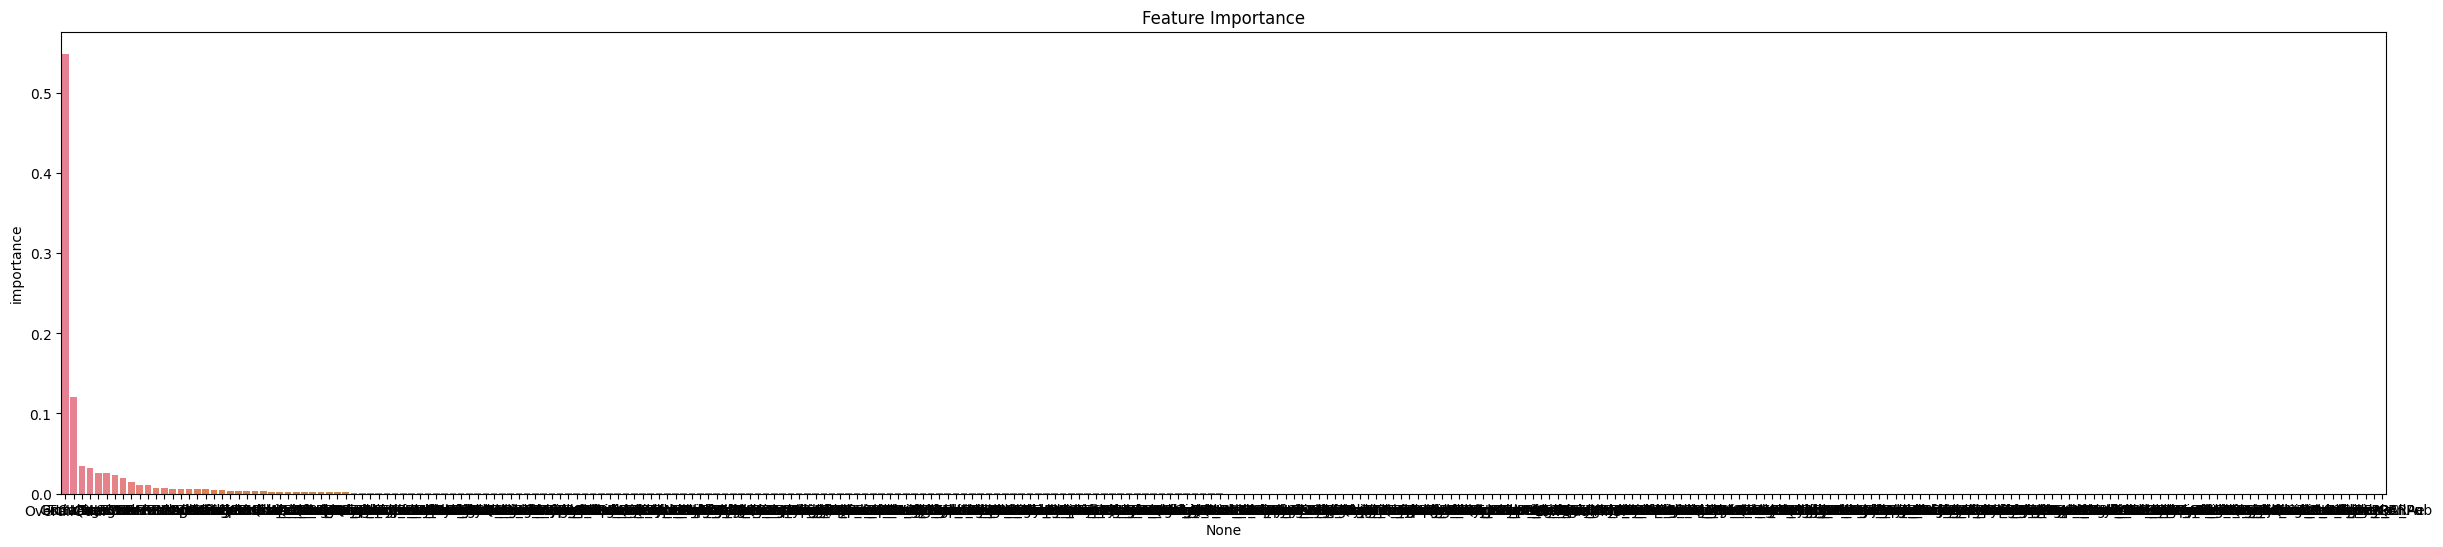

In [18]:
# Accessing 'Helpful_ml_functions' directory
%load_ext autoreload
from transformer_features import get_feature_names

# Get model object from pipeline
model = rf_pipeline.named_steps['model']

# Get feature_importances from model
importances = model.feature_importances_

# Get ColumnTransformer (preprocessor) from pipeline
rf_preprocessor = rf_pipeline.named_steps['preprocessor']

# Get feature names after preprocessing
feature_names = get_feature_names(rf_preprocessor)

# Create feature importance DataFrame
feature_importance = pd.DataFrame(data=importances, index=feature_names, columns=['importance'])

# Sort DataFrame by importance in descending order
feature_importance_sorted = feature_importance.sort_values(by='importance', ascending=False)

# Display full set of importances
plt.figure(figsize=(30, 6))
plt.title("Feature Importance")
sns.barplot(x=feature_importance_sorted.index, y=feature_importance_sorted['importance'], hue=feature_importance_sorted.index)
plt.show()

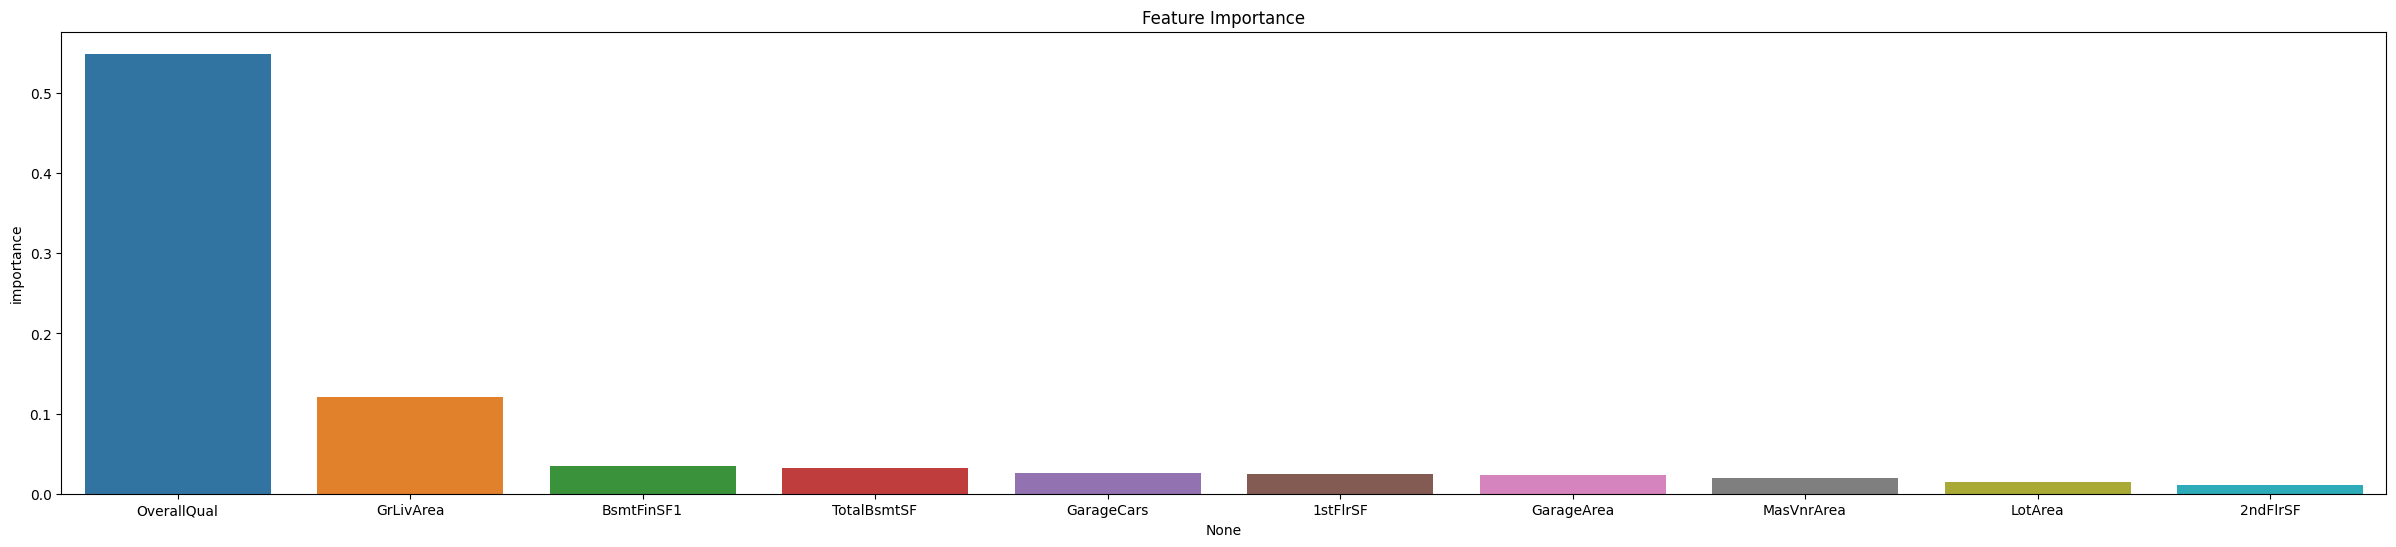

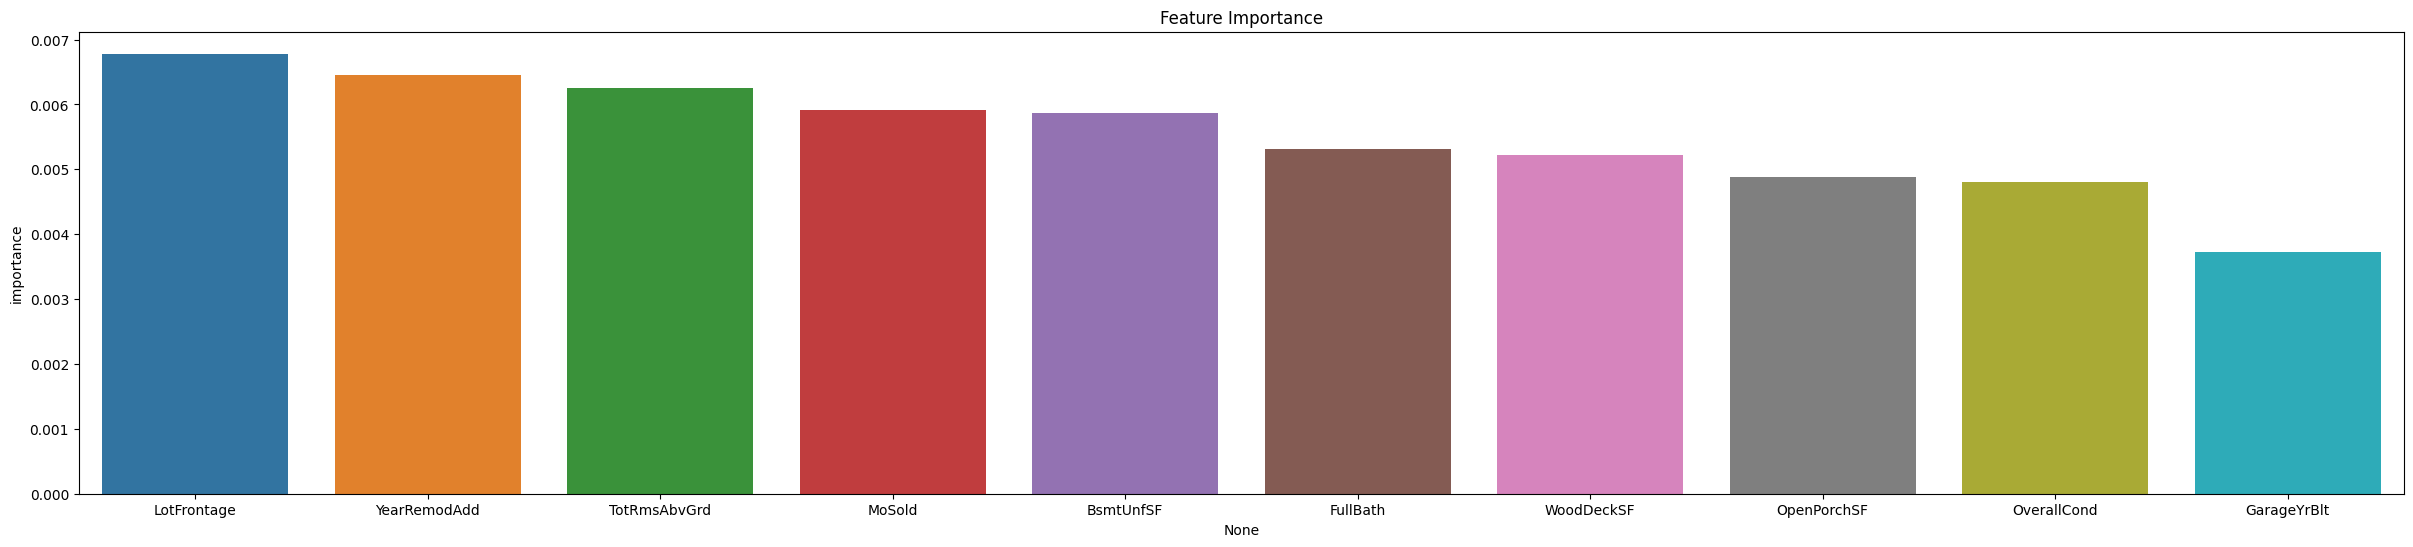

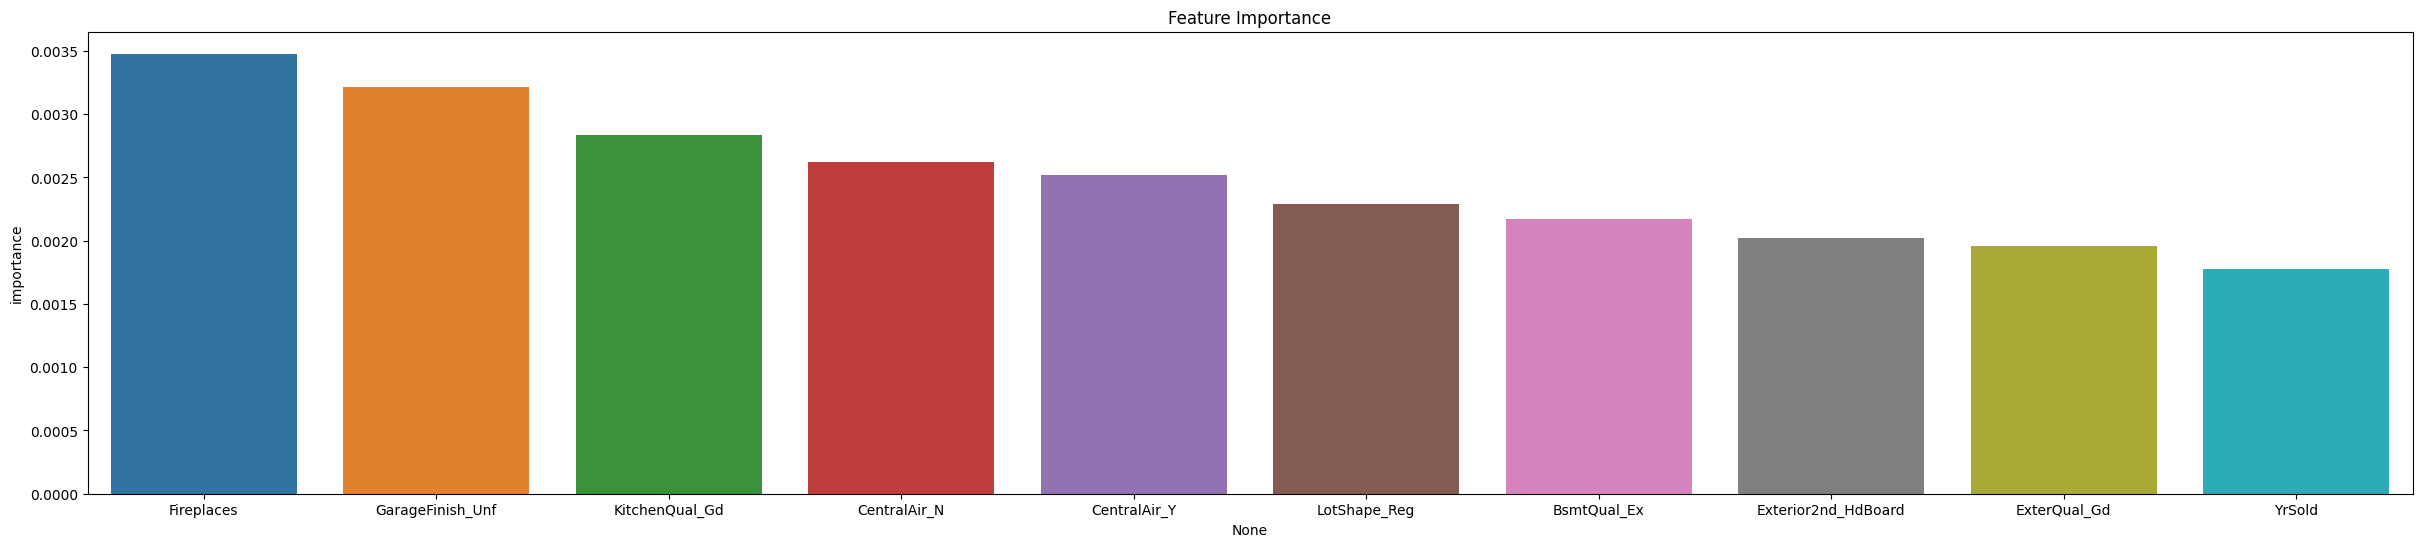

In [19]:
top_10_selected_cols = feature_importance_sorted.index[0:10]
top_10_cols_data = feature_importance_sorted['importance'][0:10]

# Display top 10 importances
plt.figure(figsize=(30, 6))
plt.title("Feature Importance")
sns.barplot(x=top_10_selected_cols, y=top_10_cols_data, hue=top_10_selected_cols)
plt.show()

# Display next 10 importances
plt.figure(figsize=(30, 6))
plt.title("Feature Importance")
sns.barplot(
    x=feature_importance_sorted.index[11:21], 
    y=feature_importance_sorted['importance'][11:21], 
    hue=feature_importance_sorted.index[11:21]
    )
plt.show()

# Display next 10 importances
plt.figure(figsize=(30, 6))
plt.title("Feature Importance")
sns.barplot(
    x=feature_importance_sorted.index[21:31], 
    y=feature_importance_sorted['importance'][21:31], 
    hue=feature_importance_sorted.index[21:31]
    )
plt.show()

In [20]:
base_feature_number = len(feature_importance_sorted.index)
base_feature_number

282

Model Accuracy Check:
- Re-evaluate the model's accuracy with the selected top features.
- Compare the accuracy with the initial full-model to understand the impact of feature selection.

In [21]:
# Transform the training data
X_train_transformed = rf_pipeline.named_steps['preprocessor'].transform(X_train)

# Retrieve feature names for the numerical features
numerical_features = numerical_cols  # already defined in your code

# Retrieve feature names for the one-hot encoded categorical features
categorical_features = rf_pipeline.named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(categorical_cols)

# Combine all feature names
all_features = numerical_features + categorical_features.tolist()

# Reconstruct the DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_features)

X_train_transformed_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,69.0,9375.0,7.0,5.0,1997.0,1998.0,573.0,739.0,0.0,318.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,69.0,2887.0,6.0,5.0,1996.0,1997.0,0.0,1003.0,0.0,288.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,50.0,7207.0,5.0,7.0,1958.0,2008.0,0.0,696.0,0.0,162.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,60.0,9060.0,6.0,5.0,1939.0,1950.0,0.0,204.0,0.0,356.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,60.0,8400.0,2.0,5.0,1920.0,1950.0,0.0,290.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [22]:
X_train_transformed_df.shape

(1022, 282)

In [23]:
nulls = X_train_transformed_df.isnull().sum().to_frame()
nulls.columns = ['nulls']
nulls.isnull().sum()

nulls    0
dtype: int64

In [24]:
# Transform the testing data
X_test_transformed = rf_pipeline.named_steps['preprocessor'].transform(X_test)

# Reconstruct the DataFrame
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_features)

X_test_transformed_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,69.0,32668.0,6.0,3.0,1957.0,1975.0,0.0,1219.0,0.0,816.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,79.0,9490.0,6.0,7.0,1941.0,1950.0,0.0,403.0,165.0,238.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,69.0,7015.0,5.0,4.0,1950.0,1950.0,161.0,185.0,0.0,524.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,83.0,10005.0,7.0,5.0,1977.0,1977.0,299.0,392.0,0.0,768.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,21.0,1680.0,6.0,5.0,1971.0,1971.0,381.0,0.0,0.0,525.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [25]:
X_test_transformed_df.shape

(438, 282)

In [26]:
from model_scoring import feature_selection_score

# Define range of selected features
n_features = range(30, 294, 10)

# Calculate model scores per number of features + score differences from base model
model_scores = feature_selection_score(
    n_features=n_features, 
    importance_frame=feature_importance_sorted,
    X_train_frame=X_train_transformed_df,
    y_train=y_train,
    X_test_frame=X_test_transformed_df,
    y_test=y_test,
    base_mse=mse_base
    )

mse_list = model_scores['mse_list']
mse_differences = model_scores['mse_differences']

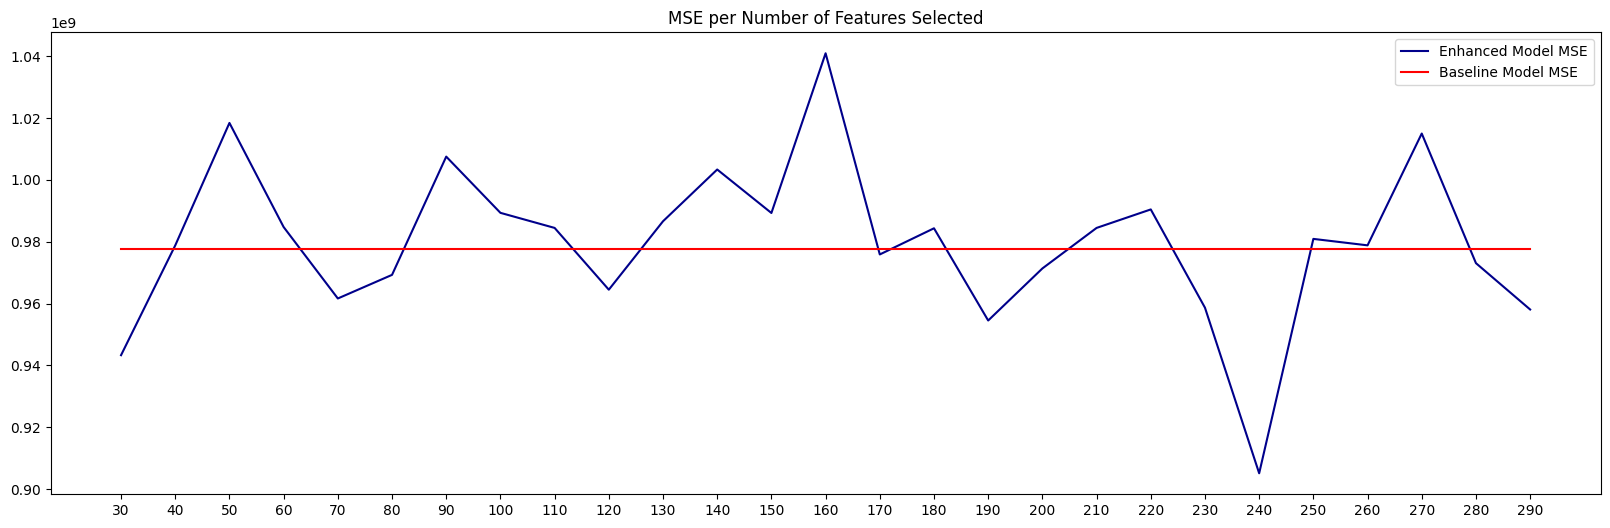

In [27]:
plt.figure(figsize=(20, 6))
plt.title("MSE per Number of Features Selected")
ax = sns.lineplot(x=n_features, y=mse_list, c='DarkBlue', legend='full', label='Enhanced Model MSE')
sns.lineplot(x=n_features, y=mse_base, ax=ax, c='Red', label='Baseline Model MSE')
plt.xticks(n_features)
plt.show()

- The lowest score at this stage of model development, the model with the best score is trained the top 170 features of the base RF model. - However, the figure above shows much fluctuation in model score despite having a general improvement trend as selection reaches 170 features and a general worsening trend from 170 onward.
- These fluctuations suggest that there is need to manipulate more of the original features and maybe create new ones.

,importance
OverallQual,3.509214e-01
OverallQual_cat_Excellent,1.726402e-01
GrLivArea,1.219048e-01
BsmtFinSF1,3.312616e-02
TotalBsmtSF,3.073710e-02
...,...
Utilities_NoSeWa,3.014941e-10
GarageCond_Ex,0.000000e+00
Condition2_RRAe,0.000000e+00
Foundation_Wood,0.000000e+00


### Optional
Adding Custom Features and Iterating:
- Experiment by creating custom features (e.g., combinations of existing features, polynomial features).
- Train the Random Forest model using these custom features in addition to the selected top features.
- Assess the impact of these custom features on model performance.

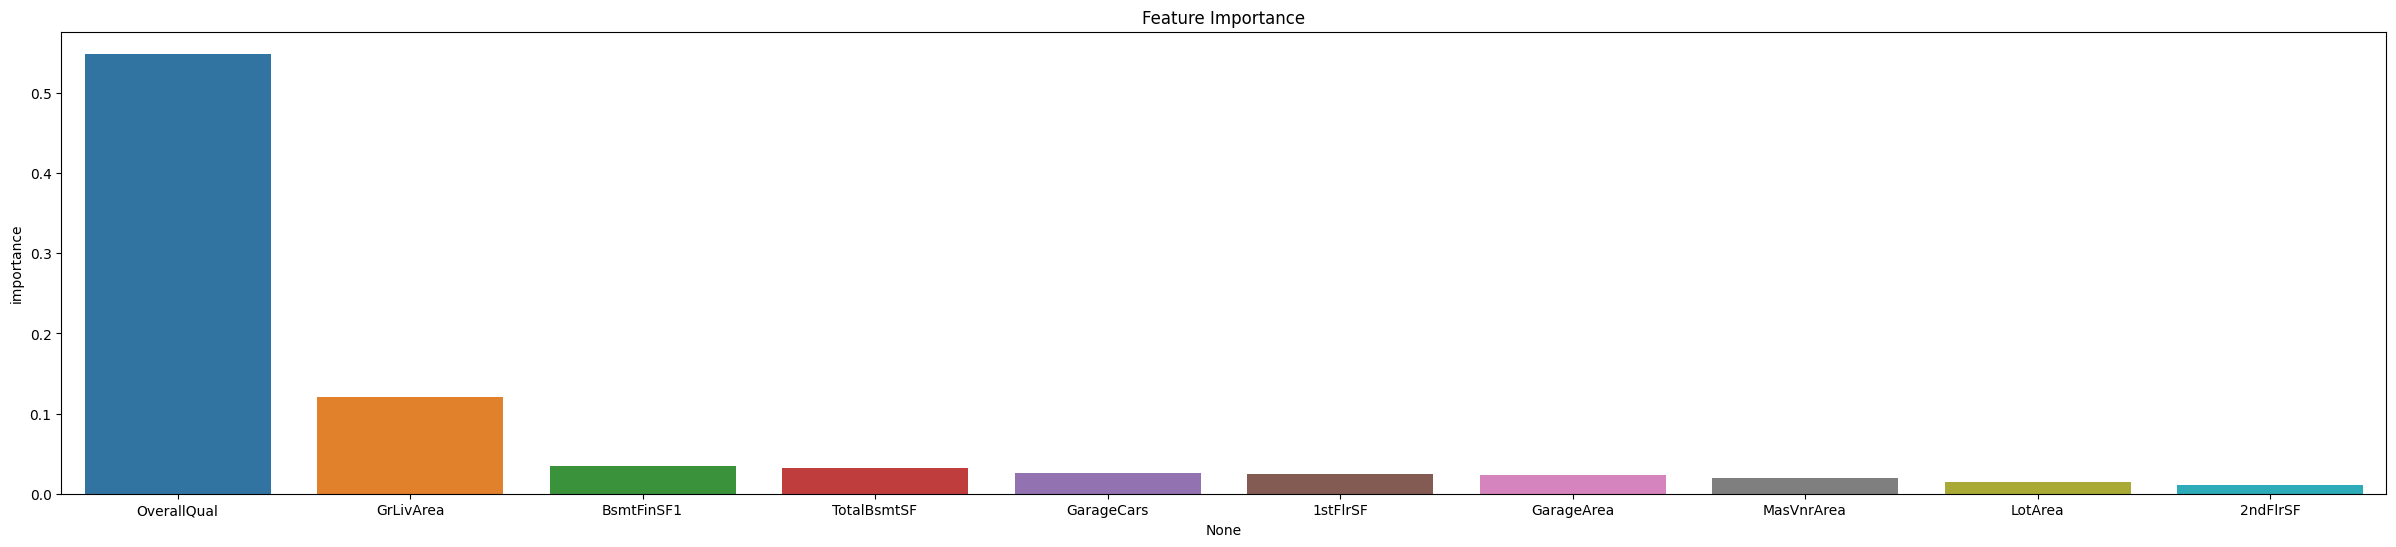

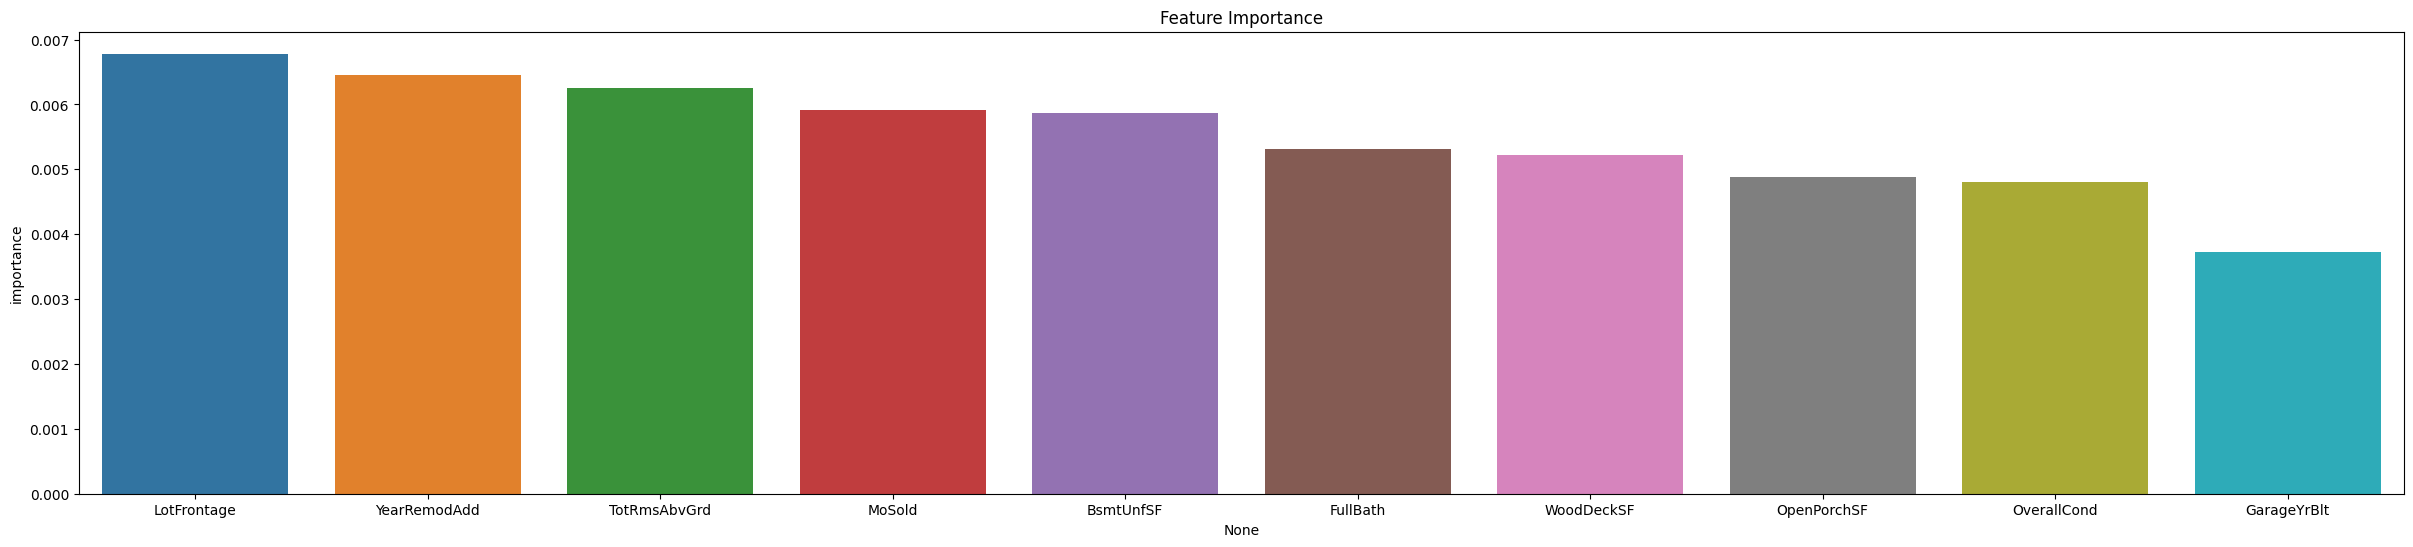

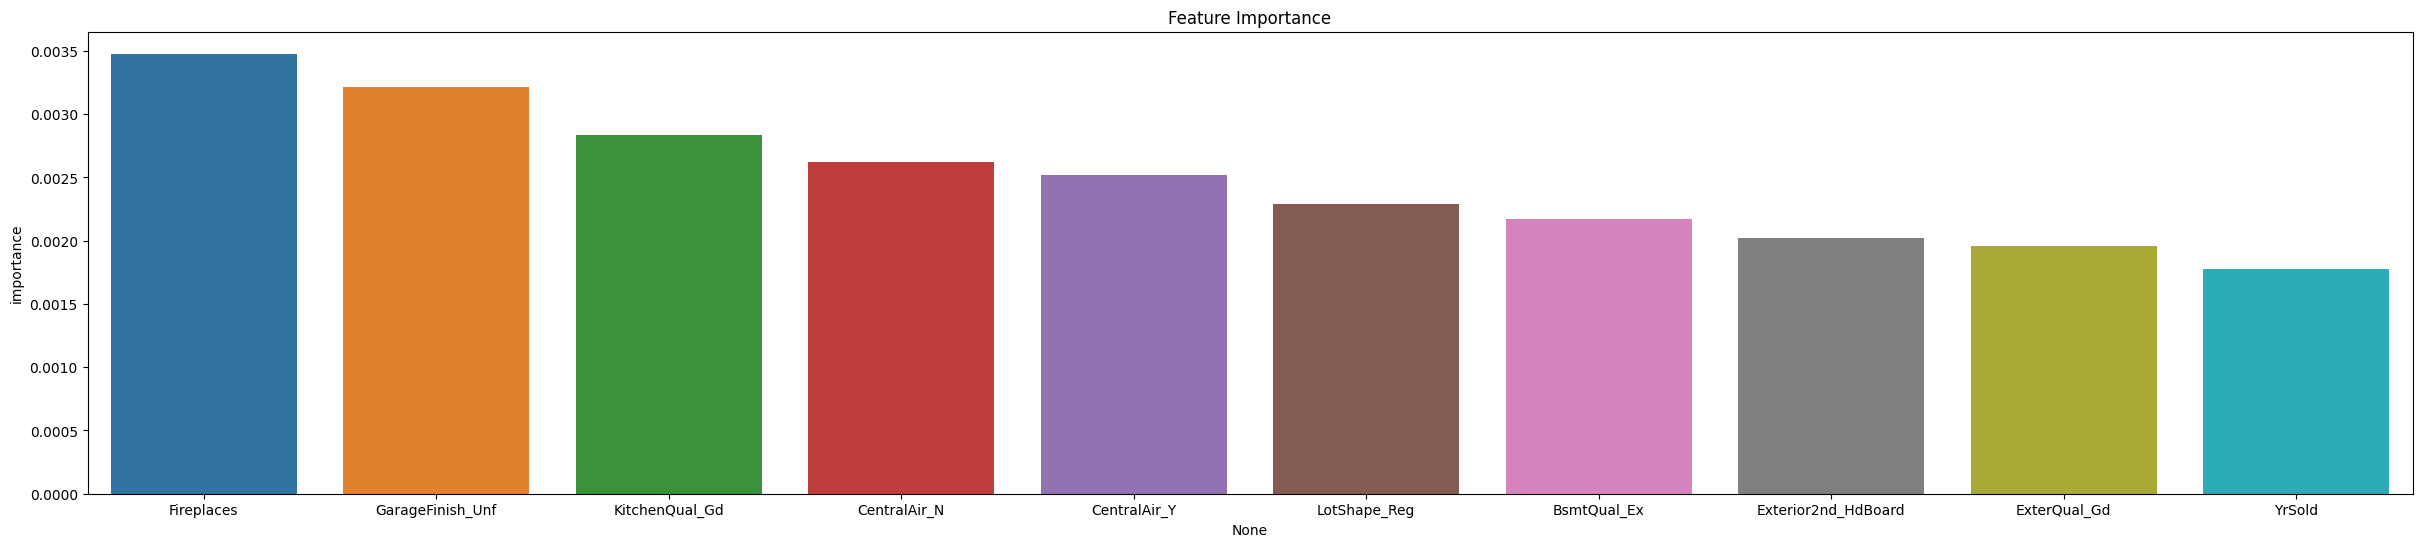

In [28]:
# Display top 10 importances
plt.figure(figsize=(30, 6))
plt.title("Feature Importance")
sns.barplot(x=top_10_selected_cols, y=top_10_cols_data, hue=top_10_selected_cols)
plt.show()

# Display next 10 importances
plt.figure(figsize=(30, 6))
plt.title("Feature Importance")
sns.barplot(
    x=feature_importance_sorted.index[11:21], 
    y=feature_importance_sorted['importance'][11:21], 
    hue=feature_importance_sorted.index[11:21]
    )
plt.show()

# Display next 10 importances
plt.figure(figsize=(30, 6))
plt.title("Feature Importance")
sns.barplot(
    x=feature_importance_sorted.index[21:31], 
    y=feature_importance_sorted['importance'][21:31], 
    hue=feature_importance_sorted.index[21:31]
    )
plt.show()

##### Custom features:
1. Percent of Masonry veneer in the lot area



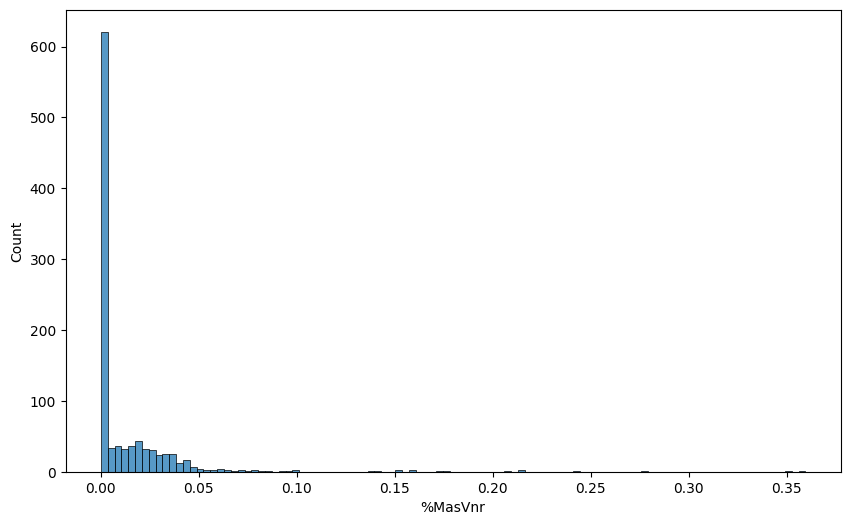

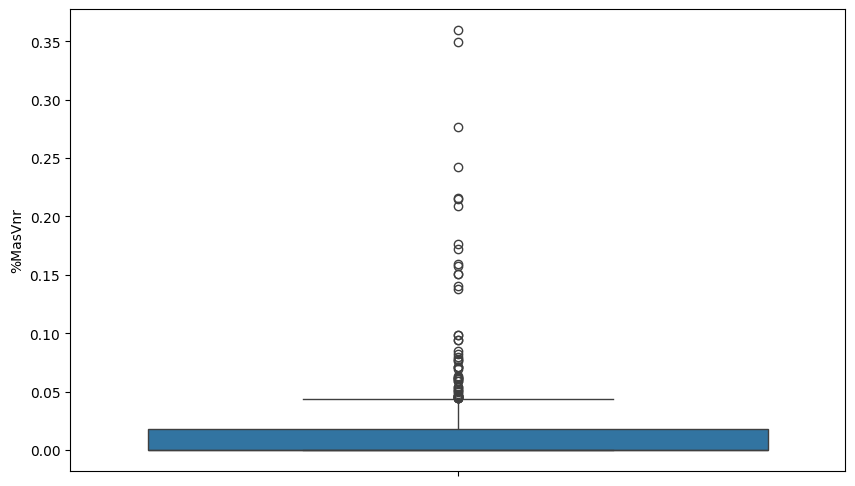

In [29]:
X_train['%MasVnr'] = X_train['MasVnrArea'] / X_train['LotArea']
X_test['%MasVnr'] = X_test['MasVnrArea'] / X_test['LotArea']

plt.figure(figsize=(10, 6))
sns.histplot(data=X_train['%MasVnr'])
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train['%MasVnr'])
plt.show()

2. Bin both 'OverallQual' and 'OverallCond'

<Axes: xlabel='OverallQual', ylabel='Count'>

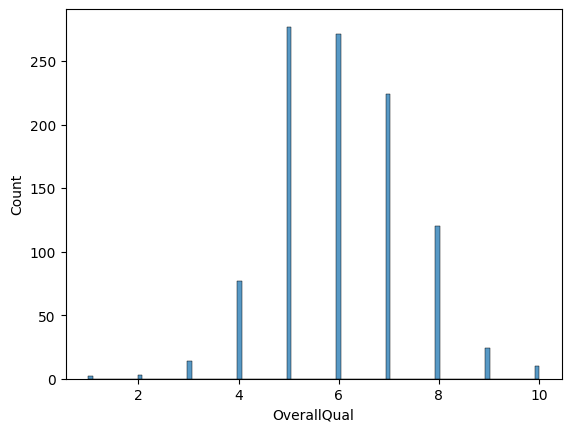

In [30]:
sns.histplot(data=X_train_transformed_df['OverallQual'], bins=100)

<Axes: xlabel='OverallCond', ylabel='Count'>

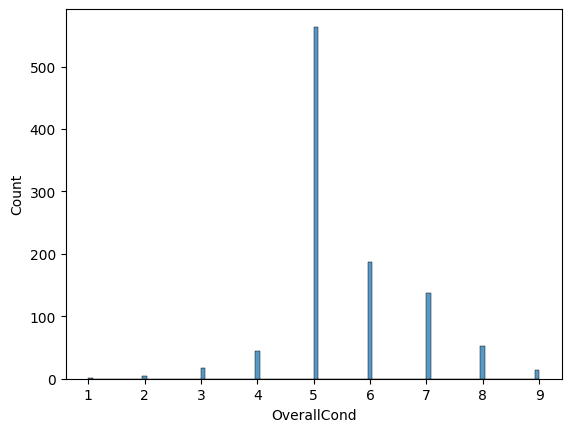

In [31]:
sns.histplot(data=X_train_transformed_df['OverallCond'], bins=100)

In [32]:
quality_labels = ['Bad', 'Average', 'Good', 'Excellent']

X_train['OverallQual_cat'] = pd.qcut(X_train['OverallQual'], q=4, labels=quality_labels)
X_test['OverallQual_cat'] = pd.qcut(X_train['OverallQual'], q=4, labels=quality_labels)
X_train['OverallQual_cat'].value_counts()

OverallQual_cat
Bad          373
Average      271
Good         224
Excellent    154
Name: count, dtype: int64

In [33]:
X_train['OverallCond_cat'] = pd.qcut(X_train['OverallCond'], q=3, labels=quality_labels[:-1])
X_test['OverallCond_cat'] = pd.qcut(X_train['OverallCond'], q=3, labels=quality_labels[:-1])
X_train['OverallCond_cat'].value_counts()

OverallCond_cat
Bad        632
Good       203
Average    187
Name: count, dtype: int64

3. Percent of finished basement area type 1

In [34]:
X_train['%BsmtFin1'] = X_train['BsmtFinSF1'] / X_train['TotalBsmtSF']
X_test['%BsmtFin1'] = X_test['BsmtFinSF1'] / X_test['TotalBsmtSF']

4. 'MoSold' binned to months

<Axes: xlabel='MoSold', ylabel='Count'>

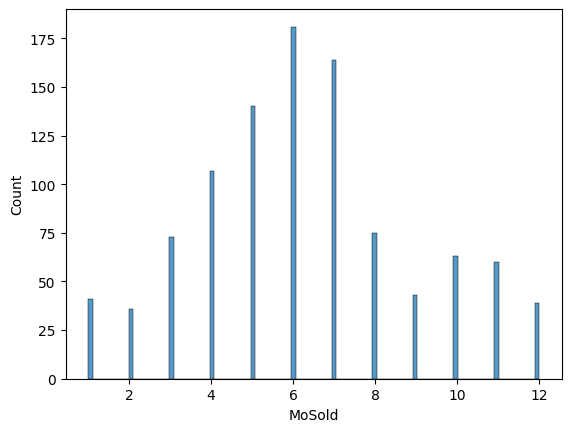

In [35]:
sns.histplot(data=X_train['MoSold'], bins=100)

<Axes: xlabel='MoSold', ylabel='SalePrice'>

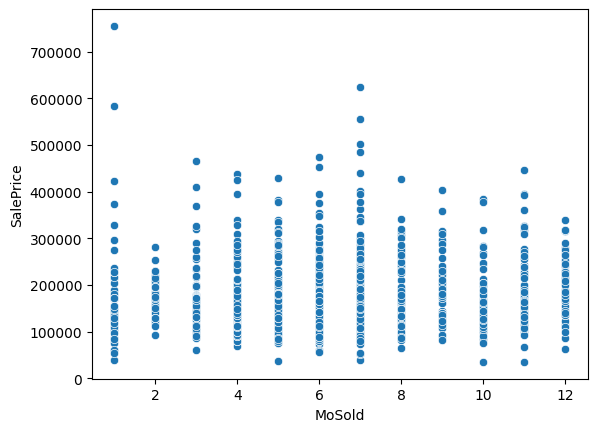

In [36]:
sns.scatterplot(x=X_train['MoSold'], y=y_train)

In [37]:
months = {
    1: 'Jan', 
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
    }

X_train['MoSold'] = X_train['MoSold'].map(months)
X_test['MoSold'] = X_test['MoSold'].map(months)

X_train['MoSold'].isnull().sum()

0

In [38]:
X_train['MoSold'] = X_train['MoSold'].astype('object')
X_test['MoSold'] = X_test['MoSold'].astype('object')

4. 'MSSubClass' categorized

In [39]:
ms_subclass_cat = [
    '1-STORY 1946 & NEWER ALL STYLES', 
    '1-STORY 1945 & OLDER', 
    '1-STORY W/FINISHED ATTIC ALL AGES', 
    '1-1/2 STORY - UNFINISHED ALL AGES',
    '1-1/2 STORY FINISHED ALL AGES',
    '2-STORY 1946 & NEWER',
    '2-STORY 1945 & OLDER',
    '2-1/2 STORY ALL AGES',
    'SPLIT OR MULTI-LEVEL',
    'SPLIT FOYER',
    'DUPLEX - ALL STYLES AND AGES',
    '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
    '1-1/2 STORY PUD - ALL AGES',
    '2-STORY PUD - 1946 & NEWER',
    'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
    '2 FAMILY CONVERSION - ALL STYLES AND AGES'
]

ms_subclass_num = [20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 120, 150, 160, 180, 190]

ms_subclass_mapping = {key: value for key, value in zip(ms_subclass_num, ms_subclass_cat)}	

In [40]:
X_train['MSSubClass'] = X_train['MSSubClass'].map(ms_subclass_mapping)
X_test['MSSubClass'] = X_test['MSSubClass'].map(ms_subclass_mapping)

<Axes: xlabel='MSSubClass', ylabel='Count'>

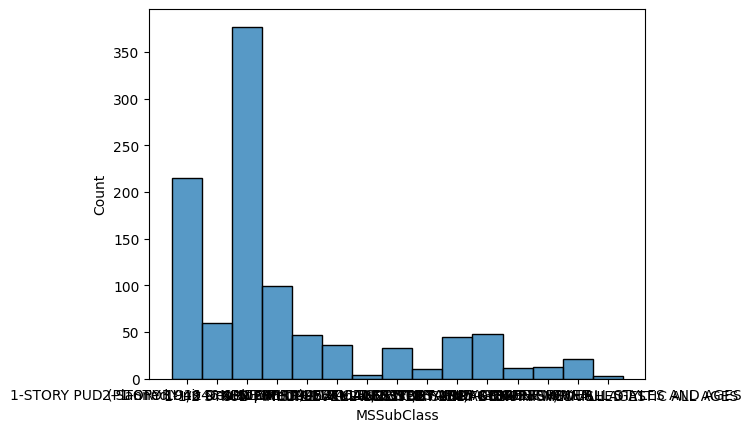

In [41]:
sns.histplot(data=X_train['MSSubClass'])

5. Percent of 'GrLivArea' out of 'LotArea'

In [42]:
X_train['%LvArea'] = X_train['GrLivArea'] / X_train['LotArea']
X_test['%LvArea'] = X_test['GrLivArea'] / X_test['LotArea']

Training the Random Forest model using these custom features in addition to the selected top features.

In [43]:
# Isolate numerical columns from other feature columns
numerical_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]

categorical_cols = X_train.columns.drop(numerical_cols)

X_train_categorical = X_train[categorical_cols]

# Check for null values
X_train_categorical.isna().sum()

MSSubClass            0
MSZoning              0
Street                0
Alley               960
LotShape              0
LandContour           0
Utilities             0
LotConfig             0
LandSlope             0
Neighborhood          0
Condition1            0
Condition2            0
BldgType              0
HouseStyle            0
RoofStyle             0
RoofMatl              0
Exterior1st           0
Exterior2nd           0
MasVnrType          614
ExterQual             0
ExterCond             0
Foundation            0
BsmtQual             24
BsmtCond             24
BsmtExposure         24
BsmtFinType1         24
BsmtFinType2         25
Heating               0
HeatingQC             0
CentralAir            0
Electrical            1
KitchenQual           0
Functional            0
FireplaceQu         478
GarageType           54
GarageFinish         54
GarageQual           54
GarageCond           54
PavedDrive            0
PoolQC             1019
Fence               831
MiscFeature     

In [44]:
# Get names of columns with more than 800 missing values
almost_empty_cols = X_train_categorical.columns[X_train_categorical.isna().sum() > 800]

# Delete these columns from categorical columns
categorical_cols = categorical_cols.drop(almost_empty_cols)

X_train = X_train.drop(almost_empty_cols, axis=1)
X_test = X_test.drop(almost_empty_cols, axis=1)

In [45]:
# Delete 'MoSold'
X_train = X_train.drop(['MoSold'], axis=1)
X_test = X_test.drop(['MoSold'], axis=1)

categorical_cols = categorical_cols.drop(['MoSold'])

In [46]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing of categorical data
one_hot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', one_hot),
])

# Full column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ]
)

# Define a Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Full data pipeline
enhanced_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

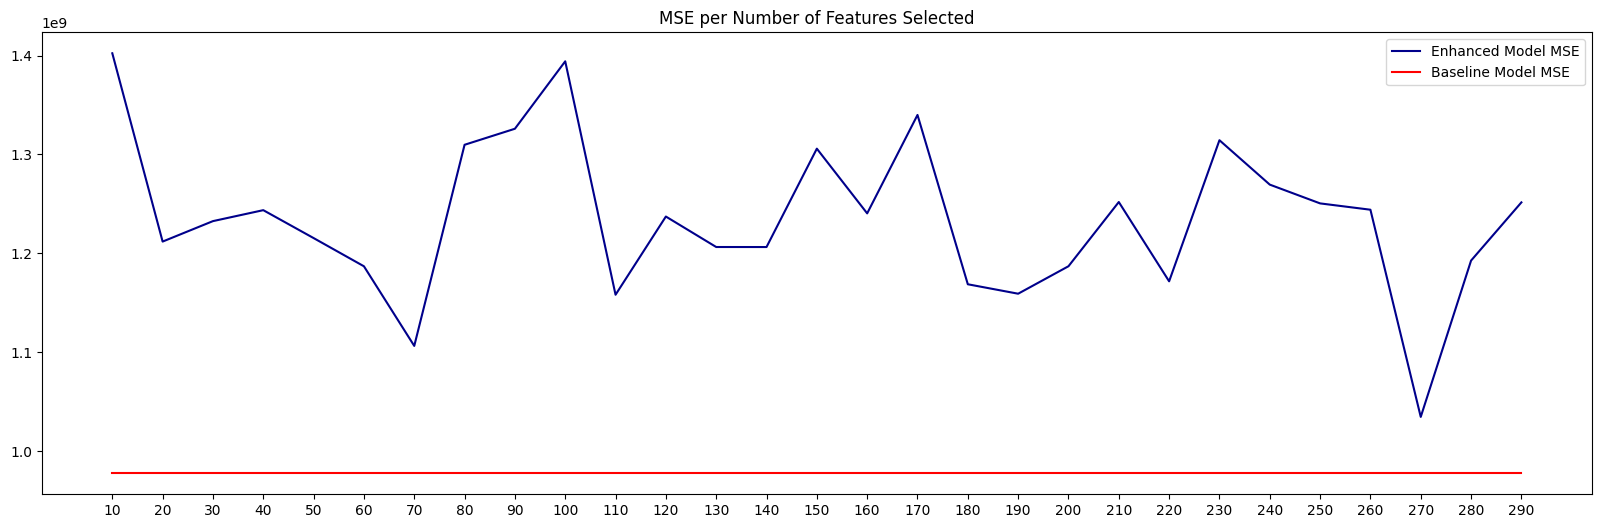

In [47]:
# Training the enhanced model
enhanced_pipeline.fit(X_train, y_train)

# Predict 'SalePrice' based on X_test
y_pred = enhanced_pipeline.predict(X_test)

# Get model object from pipeline
model = enhanced_pipeline.named_steps['model']

# Get feature_importances from model
importances = model.feature_importances_

# Get ColumnTransformer (preprocessor) from pipeline
enhanced_preprocessor = enhanced_pipeline.named_steps['preprocessor']

# Get feature names after preprocessing
feature_names = get_feature_names(enhanced_preprocessor)

# Create feature importance DataFrame
feature_importance = pd.DataFrame(data=importances, index=feature_names, columns=['importance'])

# Sort DataFrame by importance in descending order
feature_importance_sorted = feature_importance.sort_values(by='importance', ascending=False)

# Transform the training data
X_train_transformed = enhanced_pipeline.named_steps['preprocessor'].transform(X_train)

# Retrieve feature names for the numerical features
numerical_features = numerical_cols  # already defined in your code

# Retrieve feature names for the one-hot encoded categorical features
categorical_features = enhanced_pipeline.named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(categorical_cols)

# Combine all feature names
all_features = numerical_features + categorical_features.tolist()

# Reconstruct the DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_features)

# Transform the testing data
X_test_transformed = enhanced_pipeline.named_steps['preprocessor'].transform(X_test)

# Reconstruct the DataFrame
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_features)

# Calculate model scores per number of features + score differences from base model
n_features = range(10, len(X_train_transformed_df.columns) + 1, 10)

model_scores = feature_selection_score(
    n_features=n_features, 
    importance_frame=feature_importance_sorted,
    X_train_frame=X_train_transformed_df,
    y_train=y_train,
    X_test_frame=X_test_transformed_df,
    y_test=y_test,
    base_mse=mse_base
    )

mse_list = model_scores['mse_list']
mse_differences = model_scores['mse_differences']

plt.figure(figsize=(20, 6))
plt.title("MSE per Number of Features Selected")
ax = sns.lineplot(x=n_features, y=mse_list, c='DarkBlue', legend='full', label='Enhanced Model MSE')
sns.lineplot(x=n_features, y=mse_base, ax=ax, c='Red', label='Baseline Model MSE')
plt.xticks(n_features)
plt.show()

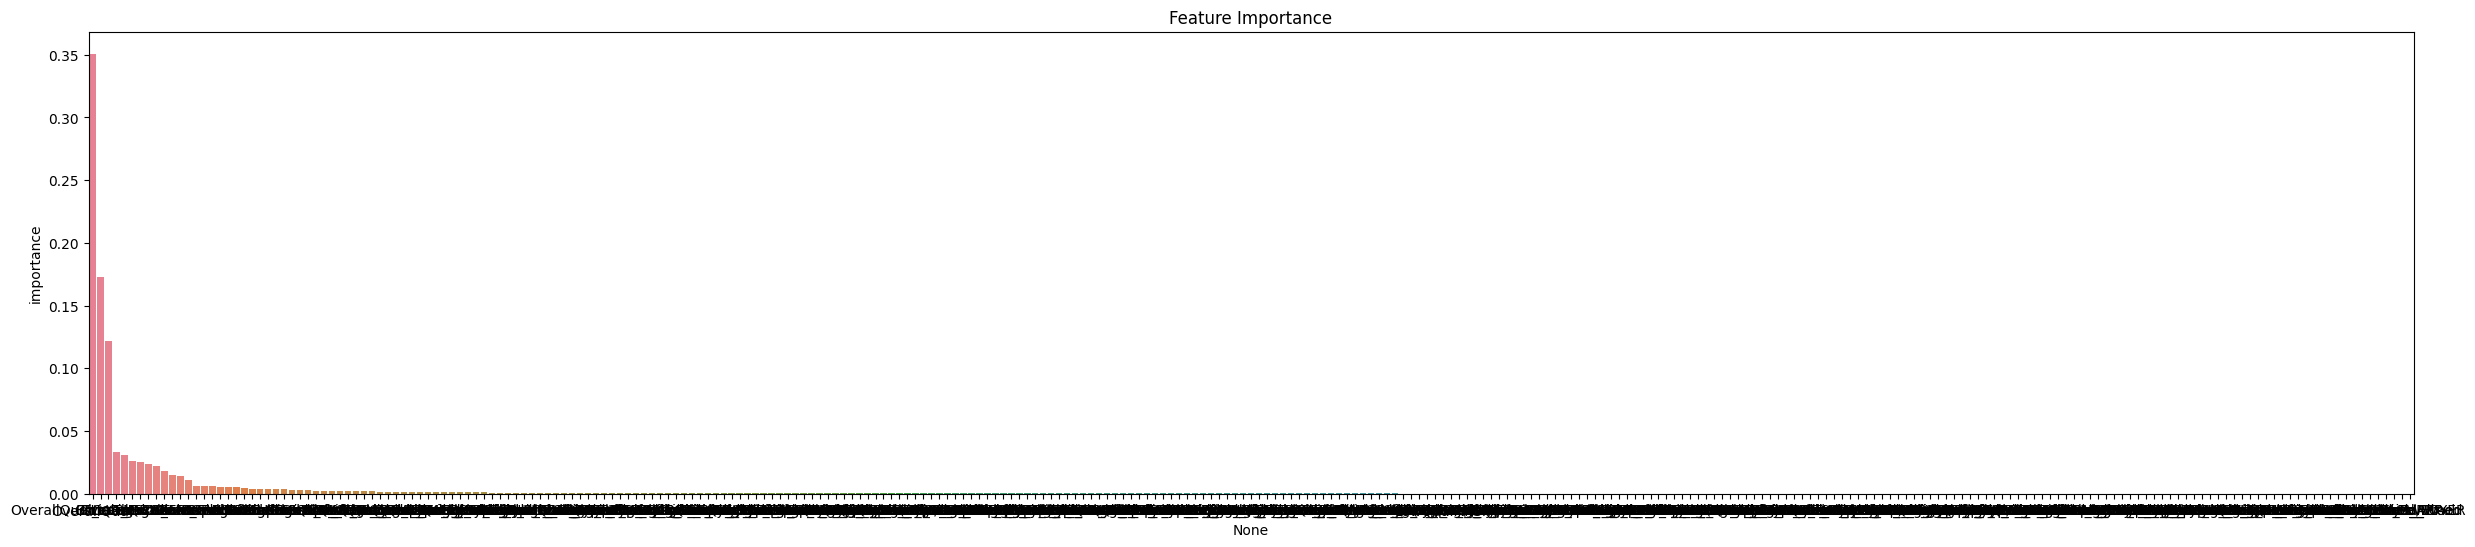

In [48]:
# Display full set of importances
plt.figure(figsize=(30, 6))
plt.title("Feature Importance")
sns.barplot(x=feature_importance_sorted.index, y=feature_importance_sorted['importance'], hue=feature_importance_sorted.index)
plt.show()

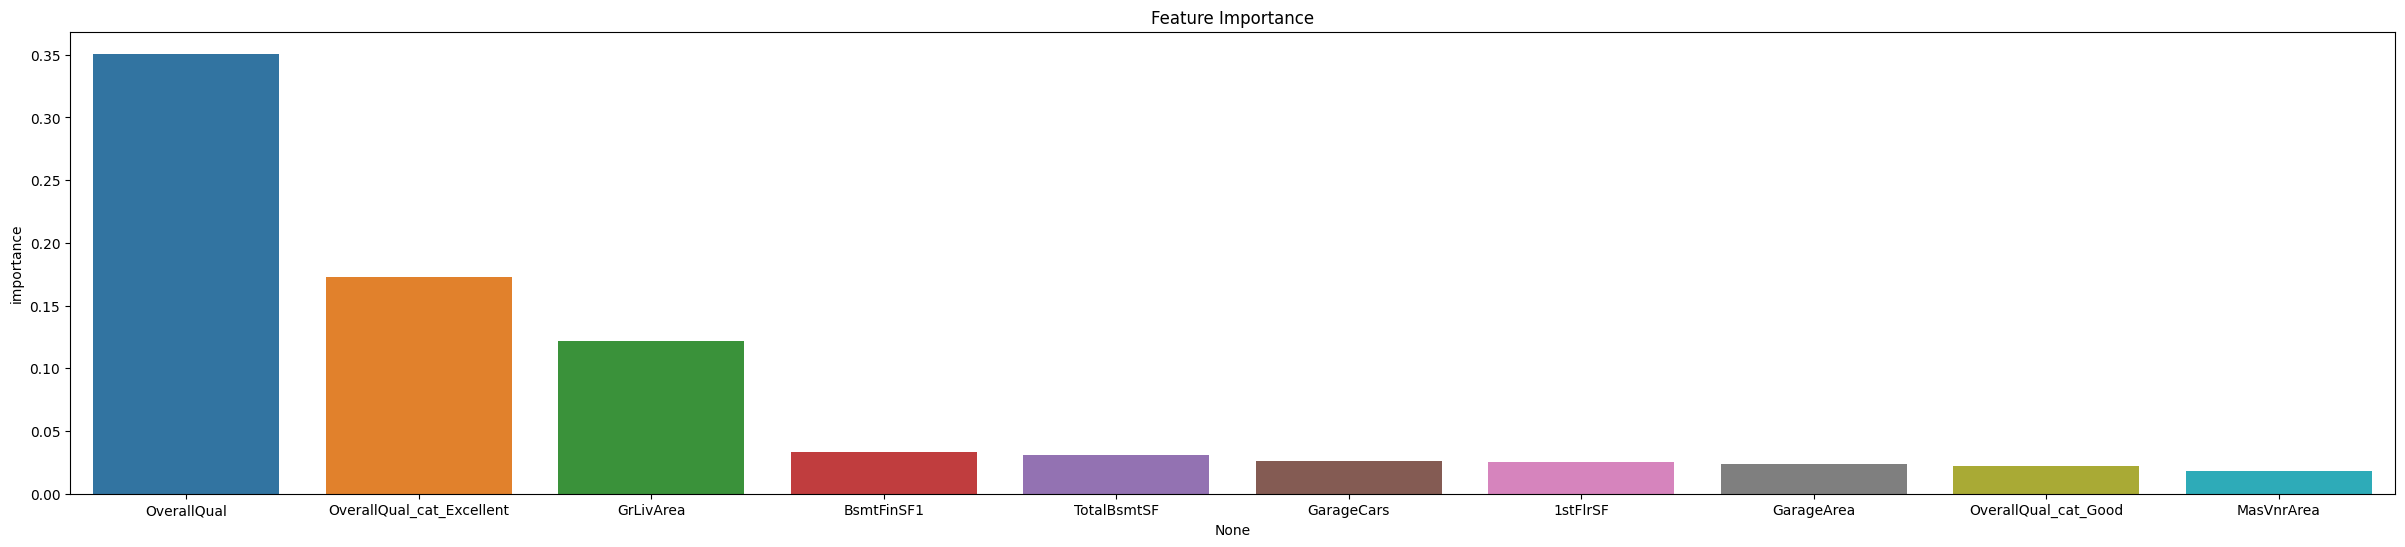

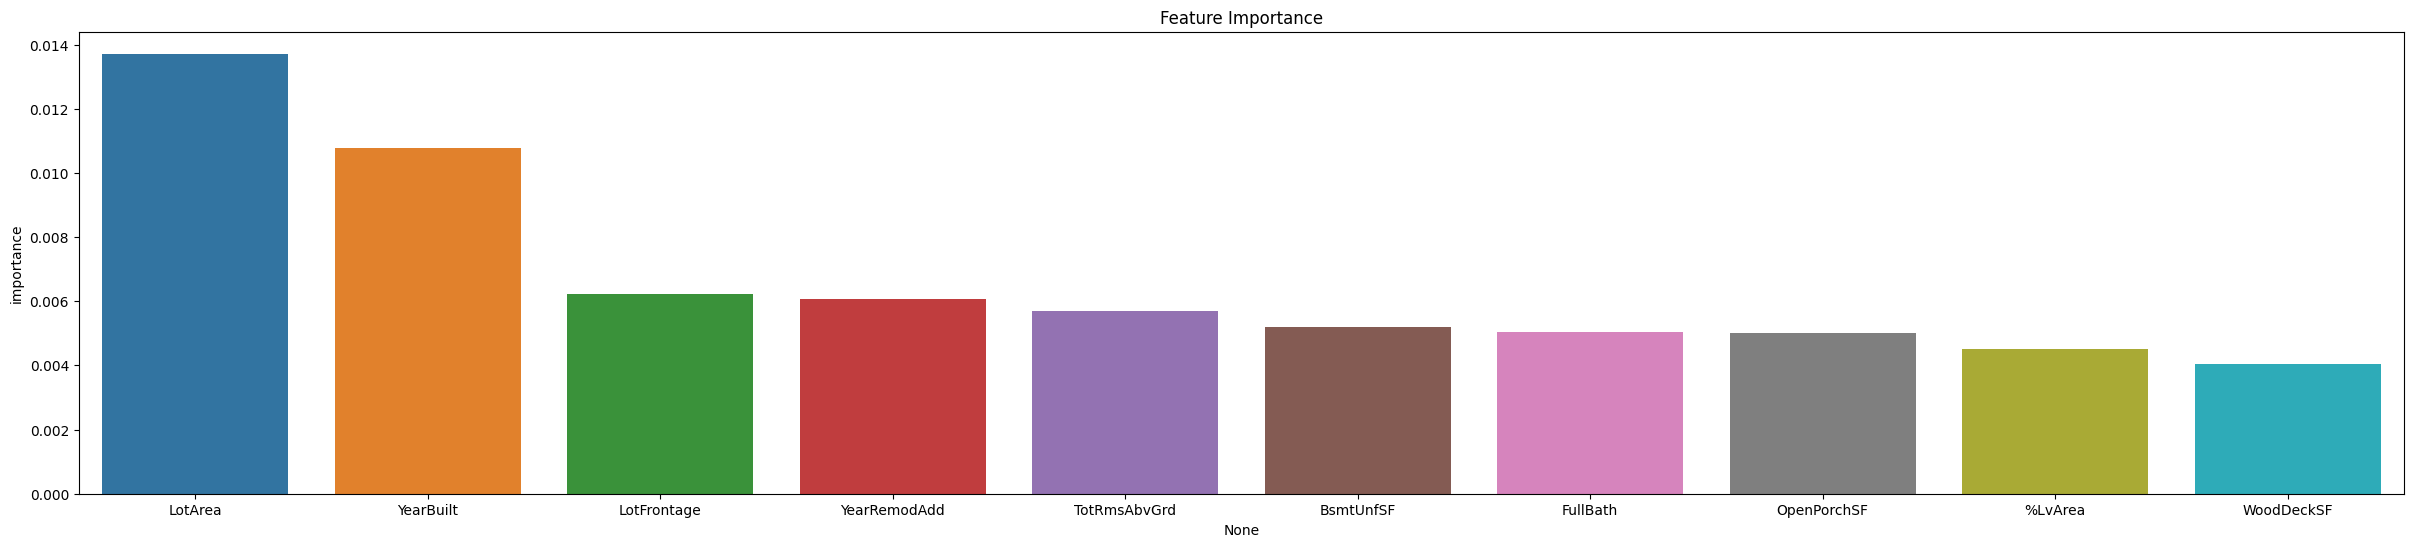

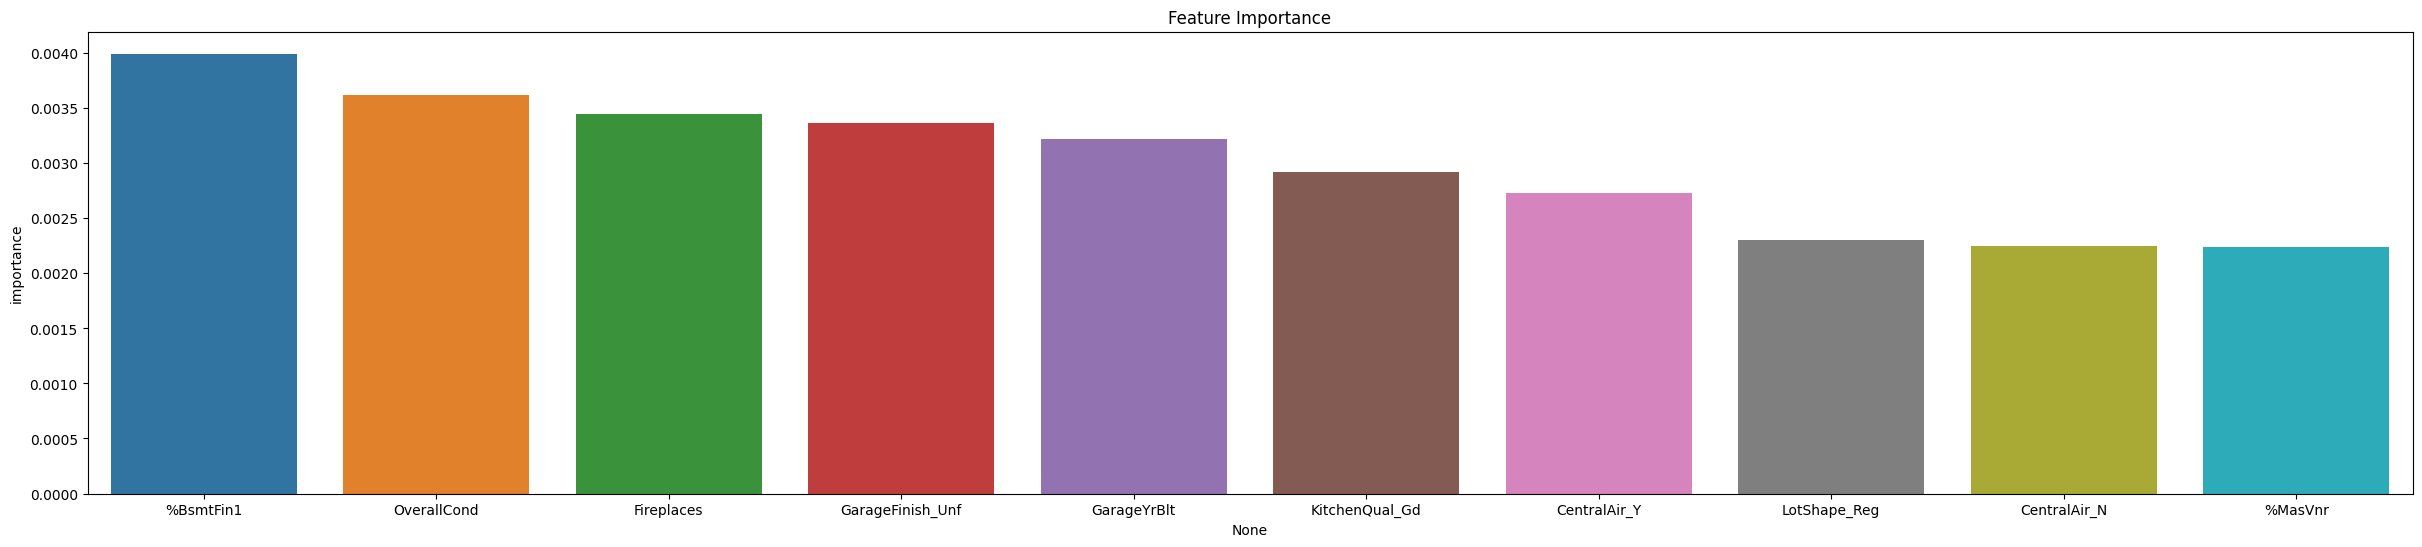

In [49]:
top_10_selected_cols = feature_importance_sorted.index[0:10]
top_10_cols_data = feature_importance_sorted['importance'][0:10]

# Display top 10 importances
plt.figure(figsize=(30, 6))
plt.title("Feature Importance")
sns.barplot(x=top_10_selected_cols, y=top_10_cols_data, hue=top_10_selected_cols)
plt.show()

# Display next 10 importances
plt.figure(figsize=(30, 6))
plt.title("Feature Importance")
sns.barplot(
    x=feature_importance_sorted.index[11:21], 
    y=feature_importance_sorted['importance'][11:21], 
    hue=feature_importance_sorted.index[11:21]
    )
plt.show()

# Display next 10 importances
plt.figure(figsize=(30, 6))
plt.title("Feature Importance")
sns.barplot(
    x=feature_importance_sorted.index[21:31], 
    y=feature_importance_sorted['importance'][21:31], 
    hue=feature_importance_sorted.index[21:31]
    )
plt.show()

In [53]:
# Get model object from pipeline
model = rf_pipeline.named_steps['model']

# Get feature_importances from model
importances = model.feature_importances_

# Get ColumnTransformer (preprocessor) from pipeline
rf_preprocessor = rf_pipeline.named_steps['preprocessor']

# Get feature names after preprocessing
feature_names = get_feature_names(rf_preprocessor)

# Create feature importance DataFrame
feature_importance = pd.DataFrame(data=importances, index=feature_names, columns=['importance'])

# Sort DataFrame by importance in descending order
feature_importance_sorted = feature_importance.sort_values(by='importance', ascending=False)

In [59]:
best_feature_selection = feature_importance_sorted[:240].index